# First Attempt at Match Prediction

First attempt at predicting match outcomes for European Soccer data

The focus for simplicity will be on the EPL with the main aim to create the functions required to engineer the features

## 1. Imports



In [54]:
# mixture of libs for web scraping, parsing and pandas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from epl.query import create_and_query
from epl.match_utils import full_table_calculator, league_table_asof, result_calculator, table_calculator

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

## 2. Running Count / Sum Feature Engineering

One thing keen to use as a feature is a local history (1, 3, 5, 10, 25 games) running stat for each team

Given we have Home vs Away this is a little tricky but we can make a few helper functions

Variables we care to be able to compute:
 - Last 1,3,5,10, season-to-date:
  - Results (can be points scored or % W, % D, % L)
  - Goals for vs against
 - Position in the league table

### 2a. Query the Premier League Data

In [2]:
# restrict to premier league only for now
div = 'E0'
df = create_and_query('matches', cols=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'], wc={'Div': ['=', div]})
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=True)
df.tail()

Running query: SELECT Season, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR FROM matches WHERE Div = 'E0'


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
35,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H
36,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A
37,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H
33,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H
32,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A


### 2b. Create GameWeek Columns

It will be helpful to have a GameWeek column for various reasons:
 - Potentially some teams play better/worse at a later stage of the season
 - To group matches by a specifc stage of the season as dates will be spread across weekends

Approach: Create cols, for each season, for each team, label matches and combine on to original df

In [3]:
df['HomeTeamGameWeek'] = np.nan
df['AwayTeamGameWeek'] = np.nan
df_cols = df.columns
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek
9910,1993/1994,1993-08-14,Arsenal,Coventry,0.0,3.0,A,NaN,NaN
9919,1993/1994,1993-08-14,West Ham,Wimbledon,0.0,2.0,A,NaN,NaN
9918,1993/1994,1993-08-14,Southampton,Everton,0.0,2.0,A,NaN,NaN
9917,1993/1994,1993-08-14,Sheffield United,Swindon,3.0,1.0,H,NaN,NaN
9916,1993/1994,1993-08-14,Oldham,Ipswich,0.0,3.0,A,NaN,NaN


In [4]:
df = df.sort_values('Date', ascending=True)
for s in df.Season.unique():
    df_s = df[df.Season == s]
    for t in df_s.HomeTeam.unique():
        df_t = df_s[(df_s.HomeTeam == t) | (df_s.AwayTeam == t)]
        df_t['HomeTeamGameWeek'] = [x for x in range(1,len(df_t)+1)]
        df_t['AwayTeamGameWeek'] = [x for x in range(1,len(df_t)+1)]

        df_t['HomeTeamGameWeek'] = np.where(df_t.HomeTeam == t, df_t['HomeTeamGameWeek'], np.nan)
        df_t['AwayTeamGameWeek'] = np.where(df_t.AwayTeam == t, df_t['AwayTeamGameWeek'], np.nan)

        df = df.combine_first(df_t[['HomeTeamGameWeek', 'AwayTeamGameWeek']])
df = df[df_cols].sort_values(['Date'])

In [5]:
df.tail(15)

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek
24,2020/2021,2020-09-27,Man City,Leicester,2.0,5.0,A,2.0,3.0
25,2020/2021,2020-09-27,West Ham,Wolves,4.0,0.0,H,3.0,3.0
22,2020/2021,2020-09-27,Sheffield United,Leeds,0.0,1.0,A,3.0,3.0
27,2020/2021,2020-09-28,Liverpool,Arsenal,3.0,1.0,H,3.0,3.0
26,2020/2021,2020-09-28,Fulham,Aston Villa,0.0,3.0,A,3.0,2.0
28,2020/2021,2020-10-03,Chelsea,Crystal Palace,4.0,0.0,H,4.0,4.0
29,2020/2021,2020-10-03,Everton,Brighton,4.0,2.0,H,4.0,4.0
30,2020/2021,2020-10-03,Leeds,Man City,1.0,1.0,D,4.0,3.0
31,2020/2021,2020-10-03,Newcastle,Burnley,3.0,1.0,H,4.0,3.0
34,2020/2021,2020-10-04,Arsenal,Sheffield United,2.0,1.0,H,4.0,4.0


### 2c. Create Table Position

Current table positioning will be very helpful to help inform games between top and bottom of the league teams

However it is tricky as we:
 - want the table as of before the game
 - need to calculate the table at each point in the season

In [63]:
def create_position_data(match_df):
    
    # first we need to use the match result data to compute the league tables at each point in time
    # 'point in time' is defined as the max date per game week
    
    # list to hold all the league tables at each week for each season
    league_tables = []

    # compute for each season
    for s in match_df.Season.unique():
        print("Computing league table for season: {}".format(s))
        # get only matches for that season and get the min game week per match up
        df_s = match_df[match_df.Season == s]
        df_s['MinGameWeek'] = df_s[['HomeTeamGameWeek', 'AwayTeamGameWeek']].min(axis=1)

        # now we get the dates that correspond to each game week
        week_dates = df_s[['Date', 'MinGameWeek']].groupby('MinGameWeek').max().to_dict()['Date']

        # for each week_date we then get the table as of that point in time
        for week, date in week_dates.items():
            # compute league table up to that point
            tab = full_table_calculator(df_s[df_s.Date <= date])
            # add on some other columns for the join
            tab['Season'] = s
            tab['GameWeek'] = week
            league_tables.append(tab)

    # concat into 1 big df
    tables_df = pd.concat(league_tables)
    # we want to only know table pre game so we need to add 1 pre merge join
    tables_df['GameWeek'] = tables_df['GameWeek'] + 1
    
    # create home and away versions to join on
    tables_df = tables_df.reset_index()
    tables_home_df = tables_df[['Season' , 'Team', 'Points', 'LeagPos', 'GameWeek']].rename(columns={'Team': 'HomeTeam', 'GameWeek': 'HomeTeamGameWeek', 'Points': 'HomeTeamPoints', 'LeagPos': 'HomeLeagPos'})
    tables_away_df = tables_df[['Season' , 'Team', 'Points', 'LeagPos', 'GameWeek']].rename(columns={'Team': 'AwayTeam', 'GameWeek': 'AwayTeamGameWeek', 'Points': 'AwayTeamPoints', 'LeagPos': 'AwayLeagPos'})
    
    # join them on
    match_df = pd.merge(left=match_df, right=tables_home_df, how='left', on=['Season', 'HomeTeamGameWeek', 'HomeTeam'])
    match_df = pd.merge(left=match_df, right=tables_away_df, how='left', on=['Season', 'AwayTeamGameWeek', 'AwayTeam'])
    
    return match_df, tables_df

In [65]:
df,tables_df = create_position_data(df)

Computing league table for season: 1993/1994
Computing league table for season: 1994/1995
Computing league table for season: 1995/1996
Computing league table for season: 1996/1997
Computing league table for season: 1997/1998
Computing league table for season: 1998/1999
Computing league table for season: 1999/1900
Computing league table for season: 2000/2001
Computing league table for season: 2001/2002
Computing league table for season: 2002/2003
Computing league table for season: 2003/2004
Computing league table for season: 2004/2005
Computing league table for season: 2005/2006
Computing league table for season: 2006/2007
Computing league table for season: 2007/2008
Computing league table for season: 2008/2009
Computing league table for season: 2009/2010
Computing league table for season: 2010/2011
Computing league table for season: 2011/2012
Computing league table for season: 2012/2013
Computing league table for season: 2013/2014
Computing league table for season: 2014/2015
Computing 

In [75]:
tables_df

,Team,MP,W,L,D,GF,GA,GD,Points,position,season,Week
0,Aston Villa,1,1.0,0.0,0.0,4.0,1.0,3.0,3,1,1993/1994,2.0
1,Coventry,1,1.0,0.0,0.0,3.0,0.0,3.0,3,2,1993/1994,2.0
2,Ipswich,1,1.0,0.0,0.0,3.0,0.0,3.0,3,3,1993/1994,2.0
3,Sheffield United,1,1.0,0.0,0.0,3.0,1.0,2.0,3,4,1993/1994,2.0
4,Everton,1,1.0,0.0,0.0,2.0,0.0,2.0,3,5,1993/1994,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20763,Man United,3,1.0,2.0,0.0,5.0,11.0,-6.0,3,16,2020/2021,5.0
20764,West Brom,4,0.0,3.0,1.0,5.0,13.0,-8.0,1,17,2020/2021,5.0
20765,Burnley,3,0.0,3.0,0.0,3.0,8.0,-5.0,0,18,2020/2021,5.0
20766,Sheffield United,4,0.0,4.0,0.0,1.0,6.0,-5.0,0,19,2020/2021,5.0


In [85]:
season_dict = dict(zip(tables_df.season.unique(), tables_df.season.unique()[1:]))
final_tables_df = tables_df[['Season', 'GameWeek']].groupby('Season').max().reset_index()
final_tables_df['PrevSeason'] = final_tables_df['Season'].map(season_dict)

new_tables_df = pd.merge(left=tables_df, right=final_tables_df, how='left', on=['Season', 'GameWeek'])
final_tables_df = new_tables_df[~new_tables_df.last_season.isna()]
final_tables_df = final_tables_df[['Team', 'PrevSeason', 'LeagPos']].rename(columns={'PrevSeason': 'Season', 'LeagPos': 'PrevLeagPos'})
final_tables_df

,Team,MP,W,L,D,GF,GA,GD,Points,position,season,Week,last_season
902,Man United,42,27.0,4.0,11.0,80.0,38.0,42.0,92,1,1993/1994,43.0,1994/1995
903,Blackburn,42,25.0,8.0,9.0,63.0,36.0,27.0,84,2,1993/1994,43.0,1994/1995
904,Newcastle,42,23.0,11.0,8.0,82.0,41.0,41.0,77,3,1993/1994,43.0,1994/1995
905,Arsenal,42,18.0,7.0,17.0,53.0,28.0,25.0,71,4,1993/1994,43.0,1994/1995
906,Leeds,42,18.0,8.0,16.0,65.0,39.0,26.0,70,5,1993/1994,43.0,1994/1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20683,West Ham,38,10.0,19.0,9.0,49.0,62.0,-13.0,39,16,2019/2020,39.0,2020/2021
20684,Aston Villa,38,9.0,21.0,8.0,41.0,67.0,-26.0,35,17,2019/2020,39.0,2020/2021
20685,Bournemouth,38,9.0,22.0,7.0,40.0,65.0,-25.0,34,18,2019/2020,39.0,2020/2021
20686,Watford,38,8.0,20.0,10.0,36.0,64.0,-28.0,34,19,2019/2020,39.0,2020/2021


In [14]:
# list to hold all the league tables at each week for each season
league_tables = []

# for each season we need to work it out
for s in df.Season.unique():
    print("Running for season: {}".format(s))
    # get only matches for that season and get the min game week per match up
    df_s = df[df.season == s]
    df_s['MinGameWeek'] = df_s[['HomeTeamGameWeek', 'AwayTeamGameWeek']].min(axis=1)
    
    # now we get the dates that correspond to each game week
    week_dates = df_s[['Date', 'MinGameWeek']].groupby('MinGameWeek').max().to_dict()['Date']
    
    # for each week_date we then get the table as of that point in time
    for week, date in week_dates.items():
        tab = full_table_calculator(df_s[df_s.Date <= date])
        # add on some other columns for the join
        tab['season'] = s
        tab['Week'] = week
        league_tables.append(tab)

# concat into 1 big df
tables_df = pd.concat(league_tables)
# we want to only know table pre game so we need to add 1
tables_df['Week'] = tables_df['Week'] + 1

Running for season: 1993/1994
Running for season: 1994/1995
Running for season: 1995/1996
Running for season: 1996/1997
Running for season: 1997/1998
Running for season: 1998/1999
Running for season: 1999/1900
Running for season: 2000/2001
Running for season: 2001/2002
Running for season: 2002/2003
Running for season: 2003/2004
Running for season: 2004/2005
Running for season: 2005/2006
Running for season: 2006/2007
Running for season: 2007/2008
Running for season: 2008/2009
Running for season: 2009/2010
Running for season: 2010/2011
Running for season: 2011/2012
Running for season: 2012/2013
Running for season: 2013/2014
Running for season: 2014/2015
Running for season: 2015/2016
Running for season: 2016/2017
Running for season: 2017/2018
Running for season: 2018/2019
Running for season: 2019/2020
Running for season: 2020/2021


In [25]:
tables_df = tables_df.reset_index()
tables_home_df = tables_df[['season' , 'Team', 'Points', 'position', 'Week']].rename(columns={'Team': 'HomeTeam', 'Week': 'HomeTeamGameWeek', 'Points': 'HomeTeamPoints', 'position': 'HomePosition'})
tables_away_df = tables_df[['season' , 'Team', 'Points', 'position', 'Week']].rename(columns={'Team': 'AwayTeam', 'Week': 'AwayTeamGameWeek', 'Points': 'AwayTeamPoints', 'position': 'AwayPosition'})
tables_home_df

,season,HomeTeam,HomeTeamPoints,HomePosition,HomeTeamGameWeek
0,1993/1994,Aston Villa,3,1,2.0
1,1993/1994,Coventry,3,2,2.0
2,1993/1994,Ipswich,3,3,2.0
3,1993/1994,Sheffield United,3,4,2.0
4,1993/1994,Everton,3,5,2.0
...,...,...,...,...,...
20763,2020/2021,Man United,3,16,5.0
20764,2020/2021,West Brom,1,17,5.0
20765,2020/2021,Burnley,0,18,5.0
20766,2020/2021,Sheffield United,0,19,5.0


In [27]:
df_new = pd.merge(left=df, right=tables_home_df, how='left', on=['season', 'HomeTeamGameWeek', 'HomeTeam'])
df_new = pd.merge(left=df_new, right=tables_away_df, how='left', on=['season', 'AwayTeamGameWeek', 'AwayTeam'])
df_new

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,HomeTeamPoints,HomePosition,AwayTeamPoints,AwayPosition
0,1993/1994,1993-08-14,Arsenal,Coventry,0.0,3.0,A,1.0,1.0,NaN,NaN,NaN,NaN
1,1993/1994,1993-08-14,West Ham,Wimbledon,0.0,2.0,A,1.0,1.0,NaN,NaN,NaN,NaN
2,1993/1994,1993-08-14,Southampton,Everton,0.0,2.0,A,1.0,1.0,NaN,NaN,NaN,NaN
3,1993/1994,1993-08-14,Sheffield United,Swindon,3.0,1.0,H,1.0,1.0,NaN,NaN,NaN,NaN
4,1993/1994,1993-08-14,Oldham,Ipswich,0.0,3.0,A,1.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10367,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0,6.0,13.0,0.0,20.0
10368,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0,3.0,14.0,7.0,6.0
10369,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0,6.0,4.0,9.0,5.0
10370,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0,6.0,11.0,1.0,17.0


In [31]:
df_new['HomePositionAdv'] = df_new['HomePosition'] - df_new['AwayPosition']
df_new.tail(10)

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,HomeTeamPoints,HomePosition,AwayTeamPoints,AwayPosition,HomePositionAdv
10362,2020/2021,2020-10-03,Chelsea,Crystal Palace,4.0,0.0,H,4.0,4.0,7.0,7.0,6.0,12.0,-5.0
10363,2020/2021,2020-10-03,Everton,Brighton,4.0,2.0,H,4.0,4.0,12.0,1.0,3.0,15.0,-14.0
10364,2020/2021,2020-10-03,Leeds,Man City,1.0,1.0,D,4.0,3.0,7.0,8.0,3.0,13.0,-5.0
10365,2020/2021,2020-10-03,Newcastle,Burnley,3.0,1.0,H,4.0,3.0,7.0,9.0,0.0,18.0,-9.0
10366,2020/2021,2020-10-04,Arsenal,Sheffield United,2.0,1.0,H,4.0,4.0,9.0,4.0,0.0,19.0,-15.0
10367,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,4.0,4.0,6.0,13.0,0.0,20.0,-7.0
10368,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,3.0,4.0,3.0,14.0,7.0,6.0,8.0
10369,2020/2021,2020-10-04,Aston Villa,Liverpool,7.0,2.0,H,3.0,4.0,6.0,4.0,9.0,5.0,-1.0
10370,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,4.0,4.0,6.0,11.0,1.0,17.0,-6.0
10371,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,4.0,9.0,3.0,6.0,10.0,-7.0


In [49]:
df_pos_comp = df_new[['HomeTeam', 'FTR', 'HomePositionAdv']].dropna().groupby(['FTR', 'HomePositionAdv']).count().reset_index()

In [62]:
pd.pivot_table(data=df[['season', 'FTR', 'HomeTeam']].groupby(['season', 'FTR']).count(), index='FTR', columns='season', values='HomeTeam')

season,1993/1994,1994/1995,1995/1996,1996/1997,1997/1998,1998/1999,1999/1900,2000/2001,2001/2002,2002/2003,2003/2004,2004/2005,2005/2006,2006/2007,2007/2008,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,2016/2017,2017/2018,2018/2019,2019/2020,2020/2021
FTR,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,128,123,96,99,101,96,101,95,114,103,92,89,111,100,104,110,91,90,116,106,123,115,116,109,108,128,116,19
D,142,134,98,119,95,115,92,101,101,90,93,96,77,98,100,97,96,111,93,108,78,93,107,84,99,71,92,3
H,192,205,186,162,184,169,187,184,165,187,150,150,192,182,176,173,193,179,171,166,179,172,157,187,173,181,172,16


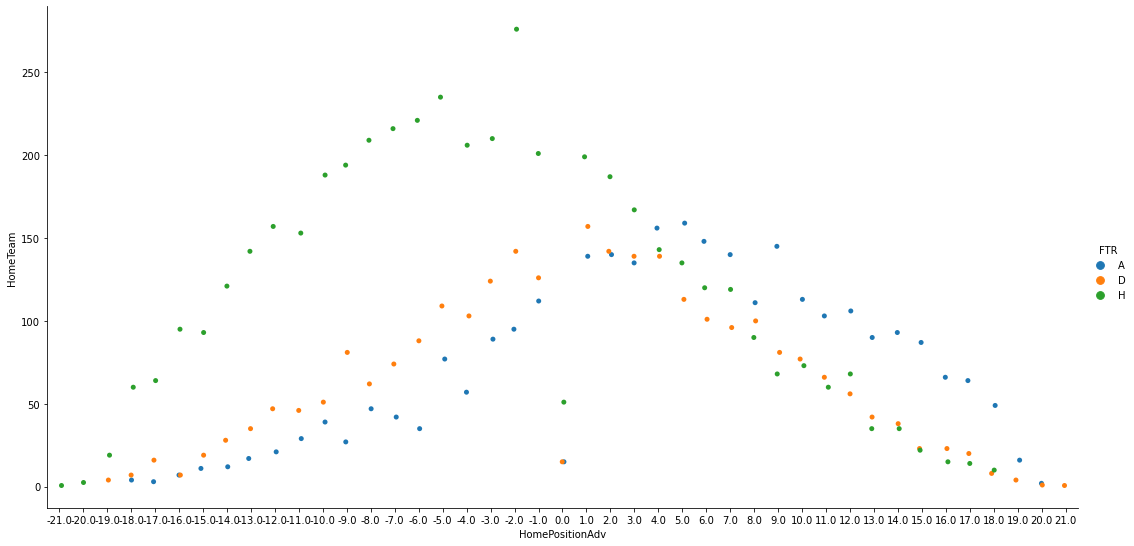

In [58]:
sns.catplot(data=df_pos_comp, x='HomePositionAdv', y='HomeTeam', hue='FTR', height=7.5, aspect=2);

In [290]:
def create_result_streak(match_df, streak_length):

    orig_cols = list(match_df.columns)
    for team in match_df.HomeTeam.unique():
        match_df = create_team_result_streak(match_df, streak_length, team)
    
    match_df = match_df[orig_cols + [x for x in match_df.columns if x not in orig_cols]]
    return match_df


def create_team_result_streak(match_df, streak_length, team):
    
    match_df = match_df.sort_values('Date')
    # get only the matches that the team has played in
    team_df = match_df[(match_df['HomeTeam'] == team) | (match_df['AwayTeam'] == team)]
    # store the original index - required to combine_first back on to match_df later
    orig_index = team_df.index
    
    # create new 'Team' and 'Opp' cols to help categorise W/D/L
    team_df['Team'] = team
    team_df['Opp'] = np.where(team_df['HomeTeam'] == team, team_df['AwayTeam'], team_df['HomeTeam'])
    
    # convert FTR H/A/D to W/D/L from perspective of team we care about
    h_map = {'H': 'W', 'D': 'D', 'A': 'L'}
    a_map = {'H': 'L', 'D': 'D', 'A': 'W'}
    team_df['Team_FTR'] = np.where(team_df['HomeTeam'] == team, team_df['FTR'].map(h_map), team_df['FTR'].map(a_map))
    
    # pivot W/D/L so we can start to create streak cols
    # we piv on the FTR col, count and fillna and then compute an offset by 1 streak (so we don't include current result)
    piv_df = pd.pivot_table(data=team_df, index=['Date', 'Team', 'HomeTeam', 'AwayTeam'], columns='Team_FTR', values='Opp', aggfunc='count')
    piv_df = piv_df.fillna(0).shift(1).rolling(streak_length).sum() / streak_length
    piv_df = piv_df.reset_index()
    
    # create the cols for Home vs Away and drop un-needed cols
    sl = str(streak_length)
    piv_df['HomeWStreak_'+sl] = np.where(piv_df['HomeTeam'] == team, piv_df['W'], np.nan)
    piv_df['HomeDStreak_'+sl] = np.where(piv_df['HomeTeam'] == team, piv_df['D'], np.nan)
    piv_df['HomeLStreak_'+sl] = np.where(piv_df['HomeTeam'] == team, piv_df['L'], np.nan)
    piv_df['AwayWStreak_'+sl] = np.where(piv_df['AwayTeam'] == team, piv_df['W'], np.nan)
    piv_df['AwayDrawStreak_'+sl] = np.where(piv_df['AwayTeam'] == team, piv_df['D'], np.nan)
    piv_df['AwayLossStreak_'+sl] = np.where(piv_df['AwayTeam'] == team, piv_df['L'], np.nan)
    piv_df = piv_df.drop(columns=['Date', 'Team', 'HomeTeam', 'AwayTeam', 'W', 'D', 'L'])
    piv_df = piv_df.set_index(orig_index)
    
    match_df = match_df.combine_first(piv_df)
    return match_df

In [343]:
df_streak = create_result_streak(df, 38)

In [344]:
df_streak['Away_Metric'] = df_streak['Away_W_38'] - df_streak['Away_L_38']
df_streak['Home_Metric'] = df_streak['Home_W_38'] - df_streak['Home_L_38']
df_streak

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeamGameWeek,AwayTeamGameWeek,Away_D_38,Away_L_38,Away_W_38,Home_D_38,Home_L_38,Home_W_38,Away_Metric,Home_Metric
0,2020/2021,2020-09-12,Fulham,Arsenal,0.0,3.0,A,1.0,1.0,0.368421,0.263158,0.368421,0.131579,0.684211,0.184211,0.105263,-0.500000
1,2020/2021,2020-09-12,Crystal Palace,Southampton,1.0,0.0,H,1.0,1.0,0.184211,0.421053,0.394737,0.263158,0.447368,0.289474,-0.026316,-0.157895
2,2020/2021,2020-09-12,Liverpool,Leeds,4.0,3.0,H,1.0,1.0,0.210526,0.552632,0.236842,0.078947,0.078947,0.842105,-0.315789,0.763158
3,2020/2021,2020-09-12,West Ham,Newcastle,0.0,2.0,A,1.0,1.0,0.289474,0.421053,0.289474,0.236842,0.500000,0.263158,-0.131579,-0.236842
4,2020/2021,2020-09-13,West Brom,Leicester,0.0,3.0,A,1.0,1.0,0.210526,0.315789,0.473684,0.342105,0.500000,0.157895,0.157895,-0.342105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10367,1993/1994,1994-05-07,Sheffield Weds,Man City,1.0,1.0,D,42.0,42.0,0.421053,0.342105,0.236842,0.368421,0.210526,0.421053,-0.105263,0.210526
10368,1993/1994,1994-05-07,Swindon,Leeds,0.0,5.0,A,42.0,42.0,0.394737,0.184211,0.421053,0.394737,0.473684,0.131579,0.236842,-0.342105
10369,1993/1994,1994-05-07,Tottenham,QPR,1.0,2.0,A,42.0,42.0,0.315789,0.315789,0.368421,0.315789,0.447368,0.236842,0.052632,-0.210526
10370,1993/1994,1994-05-07,West Ham,Southampton,3.0,3.0,D,42.0,42.0,0.157895,0.526316,0.315789,0.289474,0.368421,0.342105,-0.210526,-0.026316


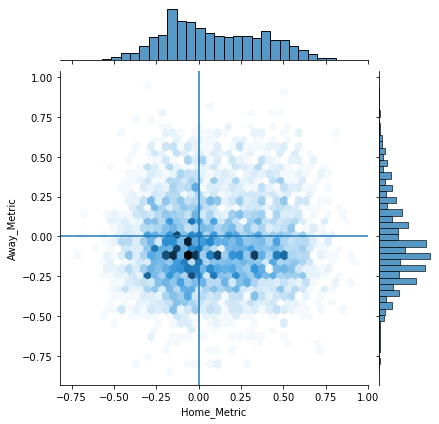

In [348]:
plot = sns.jointplot(data=df_streak[df_streak['FTR'] == 'H'], x='Home_Metric', y='Away_Metric', kind='hex');
plot.ax_joint.axvline(x=0);
plot.ax_joint.axhline(y=0);

In [342]:
df_streak[['FTR', 'Home_Metric', 'Away_Metric', 'HomeTeam']].groupby(['FTR']).mean()

,Home_Metric,Away_Metric
FTR,,
A,-0.092587,0.119777
D,-0.025927,0.018841
H,0.076271,-0.056392
